# InSituPy demonstration - Investigate gene expression along an axis using kernel densities

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
import mellon
import palantir
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)
xd.load_images()
xd.load_cells()

Loading images...
['nuclei', 'CD20', 'HER2', 'DAPI', 'HE']
Loading cells...
	No alternative cells found...


In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connec

## Calculate distance of cells to annotations

To generate an axis we use here a selected set of annotations and calculate the distance of all cells to these annotations. For demonstration purposes we selected a region of the breast cancer dataset and annotated tumor cells within this region:
<center><img src="./demo_screenshots/tumor_region_annotation_example.png" width="600"/></center>

These annotations and the region can be imported from files in the repository but of course it would be also possible to do own annotations and select an own region and save the results using `.store_geometries()`.

In [7]:
from insitupy import calc_distance_of_cells_from

In [8]:
xd.import_annotations(
    files="./demo_annotations/annotations-Tumor.geojson",
    keys="Tumor"
)

Importing annotations...


In [9]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo"
)

Importing annotations...


In [10]:
xd.import_annotations(
    files="./demo_annotations/demo_points.geojson",
    keys="Demo"
)

Importing annotations...


In [11]:
xd.import_regions(
    files="./demo_regions/regions-Tumor.geojson",
    keys="Tumor"
)

Importing regions...


In [12]:
calc_distance_of_cells_from(
    data=xd,
    annotation_key="Demo",
    annotation_class="Tumor center",
    # region_key="Tumor",
    # region_name="Selected Tumor"
)

Calculate the distance of cells from the annotation "Tumor center"
Saved distances to `.cells.matrix.obsm["distance_from"]["Tumor center"]`


In [13]:
xd.cells.matrix.obsm["distance_from"]

Tumor center
1        2480.161784
2        2487.117058
5        2477.066531
8        2473.688216
9        2463.314224
...              ...
167776   3175.216840
167777   3200.067398
167778   3190.414884
167779   3201.076376
167780   3209.733931

[163565 rows x 1 columns]

In [14]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [15]:
mask = xd.cells.matrix.obsm["distance_from"]["Tumor center"].notna()
xd.cells.matrix.obsm["distance_from"]["Tumor center"][mask]

1         2480.161784
2         2487.117058
5         2477.066531
8         2473.688216
9         2463.314224
             ...     
167776    3175.216840
167777    3200.067398
167778    3190.414884
167779    3201.076376
167780    3209.733931
Name: Tumor center, Length: 163565, dtype: float64

### Visualize the results using `napari`

Using `.show()` we can visualize the results and see the distance values per cell:
<center><img src="./demo_screenshots/distances_from_tumor_example.jpg" width="200"/></center>


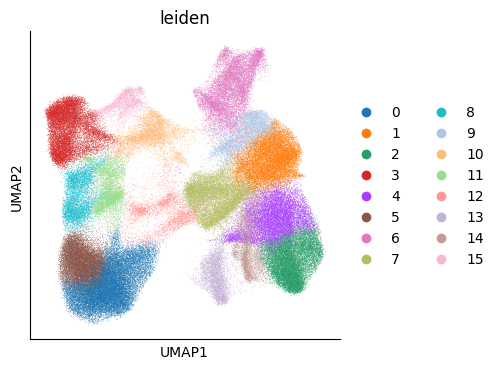

In [16]:
import scanpy as sc
sc.pl.umap(adata=xd.cells.matrix, color="leiden")

## Select small region for testing

In [17]:
xdcrop = xd.crop(region_tuple=("Tumor", "Selected Tumor"))
adata = xdcrop.cells.matrix

## Calculate density using kernel density or `Mellon`

In [18]:
from insitupy.utils._calc import calc_grouped_log_density

In [19]:

# Example usage
calc_grouped_log_density(
    adata,
    groupby='cell_type',
    mode="gauss",
    inplace=True)

100%|██████████| 18/18 [00:03<00:00,  5.60it/s]


In [20]:
# Example usage
calc_grouped_log_density(
    adata,
    groupby='cell_type',
    mode="mellon",
    inplace=True)


  0%|          | 0/18 [00:00<?, ?it/s]

[2024-10-29 22:13:05,207] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (4,399) >= n_samples (4,399) and rank = 1.0.
[2024-10-29 22:13:05,208] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:05,516] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:05,822] [INFO    ] Using covariance function Matern52(ls=239.44837480917).
[2024-10-29 22:13:08,180] [INFO    ] Using rank 4,399 covariance representation.
[2024-10-29 22:13:09,876] [INFO    ] Running inference using L-BFGS-B.


  6%|▌         | 1/18 [00:08<02:23,  8.43s/it]

[2024-10-29 22:13:13,567] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (735) >= n_samples (735) and rank = 1.0.
[2024-10-29 22:13:13,568] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:13,978] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:14,263] [INFO    ] Using covariance function Matern52(ls=355.4349887523831).
[2024-10-29 22:13:15,747] [INFO    ] Using rank 735 covariance representation.
[2024-10-29 22:13:15,929] [INFO    ] Running inference using L-BFGS-B.


 11%|█         | 2/18 [00:12<01:31,  5.73s/it]

[2024-10-29 22:13:17,400] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (585) >= n_samples (585) and rank = 1.0.
[2024-10-29 22:13:17,402] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:17,795] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:18,062] [INFO    ] Using covariance function Matern52(ls=311.61934463569906).
[2024-10-29 22:13:19,400] [INFO    ] Using rank 585 covariance representation.
[2024-10-29 22:13:19,580] [INFO    ] Running inference using L-BFGS-B.


 17%|█▋        | 3/18 [00:15<01:10,  4.73s/it]

[2024-10-29 22:13:20,946] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (539) >= n_samples (539) and rank = 1.0.
[2024-10-29 22:13:20,949] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:21,363] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:21,638] [INFO    ] Using covariance function Matern52(ls=404.20186883004015).
[2024-10-29 22:13:22,981] [INFO    ] Using rank 539 covariance representation.
[2024-10-29 22:13:23,135] [INFO    ] Running inference using L-BFGS-B.


 22%|██▏       | 4/18 [00:19<00:59,  4.26s/it]

[2024-10-29 22:13:24,499] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (5,252) and rank = 1.0.
[2024-10-29 22:13:24,501] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:24,943] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:25,218] [INFO    ] Using covariance function Matern52(ls=196.37242964432804).
[2024-10-29 22:13:25,220] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-10-29 22:13:34,802] [INFO    ] Using rank 5,000 covariance representation.
[2024-10-29 22:13:36,876] [INFO    ] Running inference using L-BFGS-B.


 28%|██▊       | 5/18 [00:35<01:51,  8.59s/it]

[2024-10-29 22:13:40,761] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2,304) >= n_samples (2,304) and rank = 1.0.
[2024-10-29 22:13:40,763] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:41,172] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:41,452] [INFO    ] Using covariance function Matern52(ls=337.37727877805037).
[2024-10-29 22:13:43,213] [INFO    ] Using rank 2,304 covariance representation.
[2024-10-29 22:13:43,699] [INFO    ] Running inference using L-BFGS-B.


 33%|███▎      | 6/18 [00:40<01:27,  7.32s/it]

[2024-10-29 22:13:45,622] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,633) and rank = 1.0.
[2024-10-29 22:13:45,623] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:13:46,076] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:13:46,355] [INFO    ] Using covariance function Matern52(ls=293.46151061703705).
[2024-10-29 22:13:46,358] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-10-29 22:13:56,037] [INFO    ] Using rank 5,000 covariance representation.
[2024-10-29 22:13:58,934] [INFO    ] Running inference using L-BFGS-B.


 39%|███▉      | 7/18 [00:58<01:59, 10.91s/it]

[2024-10-29 22:14:03,906] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,295) >= n_samples (1,295) and rank = 1.0.
[2024-10-29 22:14:03,908] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:04,331] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:04,620] [INFO    ] Using covariance function Matern52(ls=362.90922766565643).
[2024-10-29 22:14:06,169] [INFO    ] Using rank 1,295 covariance representation.
[2024-10-29 22:14:06,455] [INFO    ] Running inference using L-BFGS-B.


 44%|████▍     | 8/18 [01:03<01:28,  8.84s/it]

[2024-10-29 22:14:08,312] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (178) >= n_samples (178) and rank = 1.0.
[2024-10-29 22:14:08,314] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:08,731] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:09,010] [INFO    ] Using covariance function Matern52(ls=754.8453492752406).
[2024-10-29 22:14:10,262] [INFO    ] Using rank 178 covariance representation.
[2024-10-29 22:14:10,423] [INFO    ] Running inference using L-BFGS-B.


 50%|█████     | 9/18 [01:06<01:04,  7.14s/it]

[2024-10-29 22:14:11,736] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (58) >= n_samples (58) and rank = 1.0.
[2024-10-29 22:14:11,739] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:12,154] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:12,432] [INFO    ] Using covariance function Matern52(ls=2720.4988672303475).
[2024-10-29 22:14:13,618] [INFO    ] Using rank 58 covariance representation.
[2024-10-29 22:14:13,806] [INFO    ] Running inference using L-BFGS-B.


 56%|█████▌    | 10/18 [01:09<00:47,  5.92s/it]

[2024-10-29 22:14:14,910] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (150) >= n_samples (150) and rank = 1.0.
[2024-10-29 22:14:14,911] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:15,326] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:15,600] [INFO    ] Using covariance function Matern52(ls=1040.5173654213668).
[2024-10-29 22:14:16,855] [INFO    ] Using rank 150 covariance representation.
[2024-10-29 22:14:17,027] [INFO    ] Running inference using L-BFGS-B.


 61%|██████    | 11/18 [01:13<00:37,  5.37s/it]

[2024-10-29 22:14:19,021] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (74) >= n_samples (74) and rank = 1.0.
[2024-10-29 22:14:19,023] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:19,451] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:19,725] [INFO    ] Using covariance function Matern52(ls=1655.3290584117442).
[2024-10-29 22:14:20,921] [INFO    ] Using rank 74 covariance representation.
[2024-10-29 22:14:21,076] [INFO    ] Running inference using L-BFGS-B.


 67%|██████▋   | 12/18 [01:17<00:28,  4.73s/it]

[2024-10-29 22:14:22,300] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,064) >= n_samples (1,064) and rank = 1.0.
[2024-10-29 22:14:22,302] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:22,740] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:23,028] [INFO    ] Using covariance function Matern52(ls=232.85032589086492).
[2024-10-29 22:14:24,493] [INFO    ] Using rank 1,064 covariance representation.
[2024-10-29 22:14:24,721] [INFO    ] Running inference using L-BFGS-B.


 72%|███████▏  | 13/18 [01:21<00:22,  4.49s/it]

[2024-10-29 22:14:26,243] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (10) >= n_samples (10) and rank = 1.0.
[2024-10-29 22:14:26,245] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:26,642] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:26,904] [INFO    ] Using covariance function Matern52(ls=5370.741271655917).
[2024-10-29 22:14:28,033] [INFO    ] Using rank 10 covariance representation.
[2024-10-29 22:14:28,193] [INFO    ] Running inference using L-BFGS-B.


 78%|███████▊  | 14/18 [01:24<00:16,  4.02s/it]

[2024-10-29 22:14:29,159] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (19) >= n_samples (19) and rank = 1.0.
[2024-10-29 22:14:29,161] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:29,530] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:29,772] [INFO    ] Using covariance function Matern52(ls=3287.047799427375).
[2024-10-29 22:14:31,045] [INFO    ] Using rank 19 covariance representation.
[2024-10-29 22:14:31,199] [INFO    ] Running inference using L-BFGS-B.


 83%|████████▎ | 15/18 [01:26<00:11,  3.68s/it]

[2024-10-29 22:14:32,056] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (47) >= n_samples (47) and rank = 1.0.
[2024-10-29 22:14:32,057] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:32,323] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:32,620] [INFO    ] Using covariance function Matern52(ls=1517.943187234375).
[2024-10-29 22:14:33,943] [INFO    ] Using rank 47 covariance representation.
[2024-10-29 22:14:34,131] [INFO    ] Running inference using L-BFGS-B.


 89%|████████▉ | 16/18 [01:30<00:07,  3.59s/it]

[2024-10-29 22:14:35,425] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (99) >= n_samples (99) and rank = 1.0.
[2024-10-29 22:14:35,427] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:35,830] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:36,117] [INFO    ] Using covariance function Matern52(ls=1095.5308088746292).
[2024-10-29 22:14:37,375] [INFO    ] Using rank 99 covariance representation.
[2024-10-29 22:14:37,542] [INFO    ] Running inference using L-BFGS-B.


 94%|█████████▍| 17/18 [01:33<00:03,  3.54s/it]

[2024-10-29 22:14:38,847] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2) >= n_samples (2) and rank = 1.0.
[2024-10-29 22:14:38,849] [INFO    ] Computing nearest neighbor distances.
[2024-10-29 22:14:39,190] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-29 22:14:39,430] [INFO    ] Using covariance function Matern52(ls=35080.27609941753).
[2024-10-29 22:14:40,513] [INFO    ] Using rank 2 covariance representation.
[2024-10-29 22:14:40,672] [INFO    ] Running inference using L-BFGS-B.


100%|██████████| 18/18 [01:36<00:00,  5.36s/it]


In [21]:
xdcrop.show()

In [22]:
from insitupy import CustomPalettes
import matplotlib.pyplot as plt

In [23]:
from insitupy._constants import DEFAULT_CATEGORICAL_CMAP

In [24]:
from insitupy.plotting import cell_abundance_along_obs_val

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:694: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.histplot(data=data, x=obs_val,


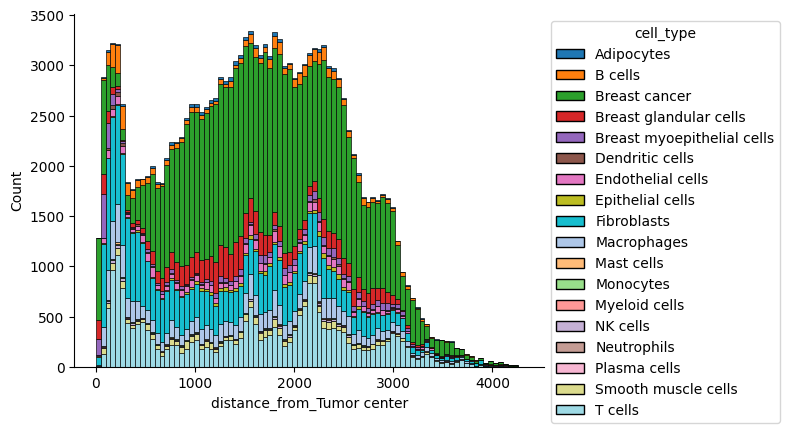

In [25]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    #xlim=(0,400),
    figsize=(8,4.5), kde=False
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:700: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.kdeplot(data=data, x=obs_val,


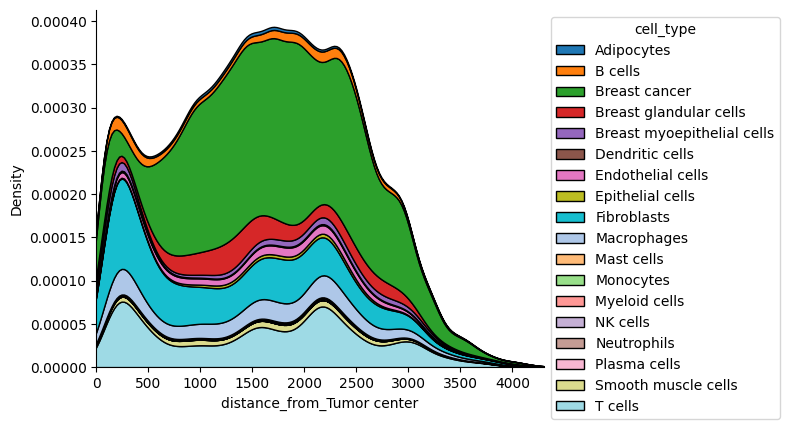

In [26]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    #xlim=(0,400),
    figsize=(8,4.5), kde=True
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:694: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.histplot(data=data, x=obs_val,


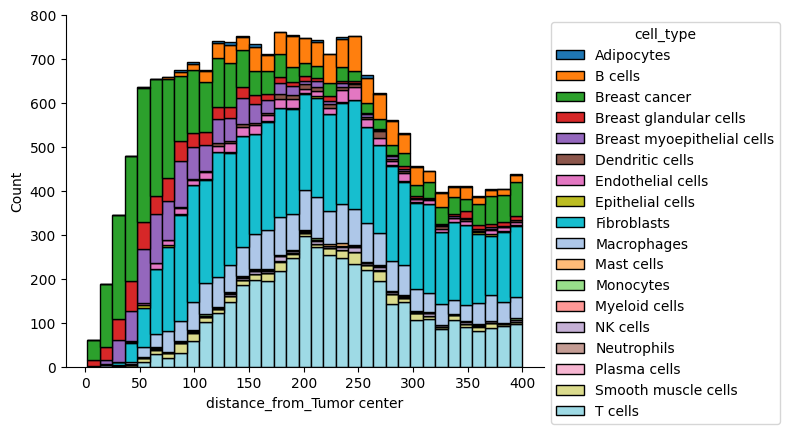

In [27]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    xlim=(0,400),
    figsize=(8,4.5), kde=False
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:700: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.kdeplot(data=data, x=obs_val,


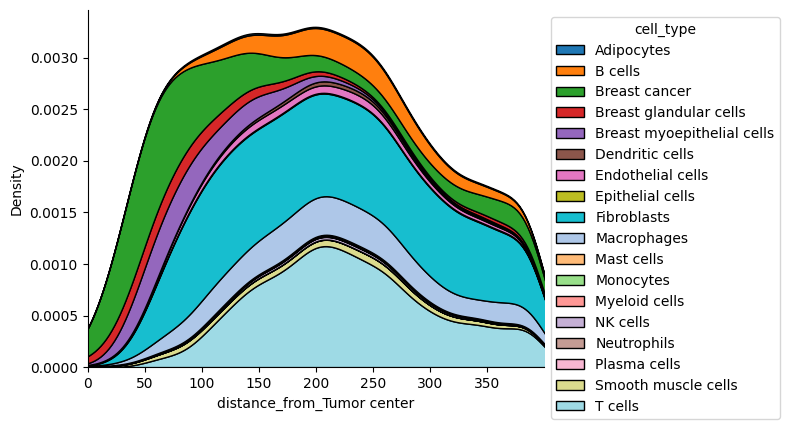

In [28]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    xlim=(0,400),
    figsize=(8,4.5), kde=True
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:700: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.kdeplot(data=data, x=obs_val,


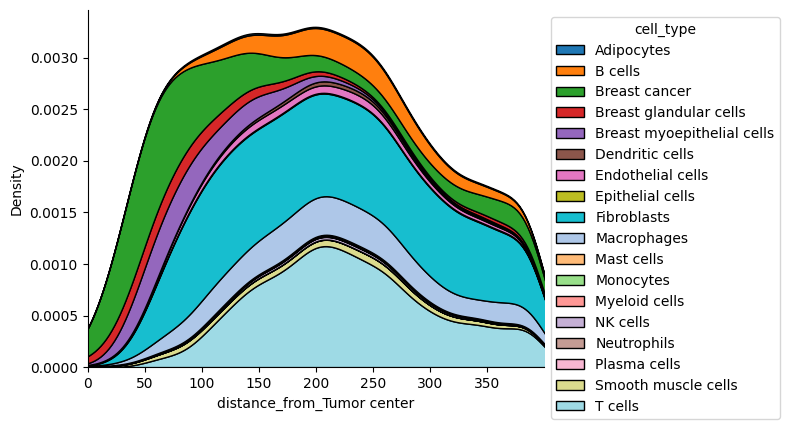

In [29]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    xlim=(0,400),
    figsize=(8,4.5), kde=True
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:700: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.kdeplot(data=data, x=obs_val,


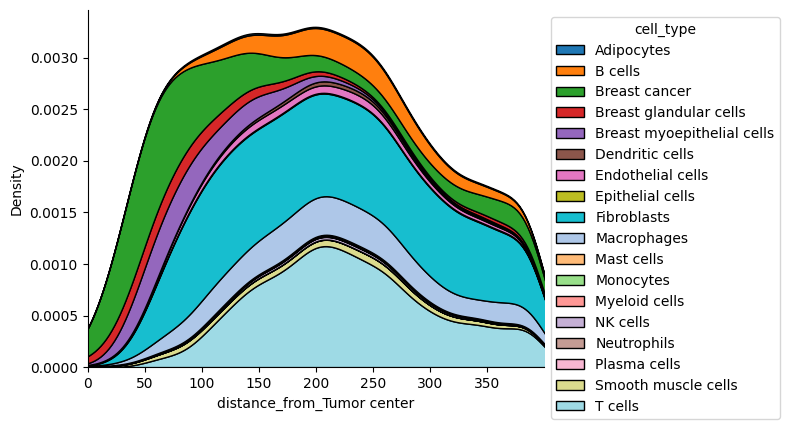

In [30]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    xlim=(0,400),
    figsize=(8,4.5), kde=True
)

In [32]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    gene="ACTA2",
    xlim=(0, 400)
    )

TypeError: cell_expression_along_axis() got an unexpected keyword argument 'gene'

In [33]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    gene="KRT8",
    xlim=(0, 400),
    #min_expression=1.5
    )


TypeError: cell_expression_along_axis() got an unexpected keyword argument 'gene'

Retrieve `obs_val` from .obsm.


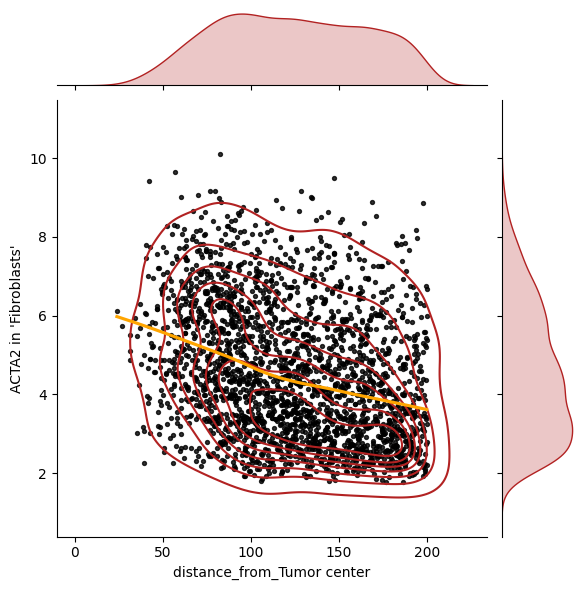

In [ ]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes="ACTA2",
    xlim=(0, 200),
    min_expression=1.5
    )


Retrieve `obs_val` from .obsm.


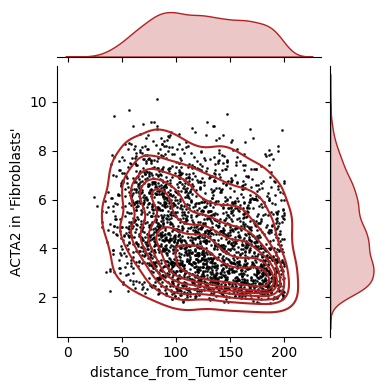

Retrieve `obs_val` from .obsm.


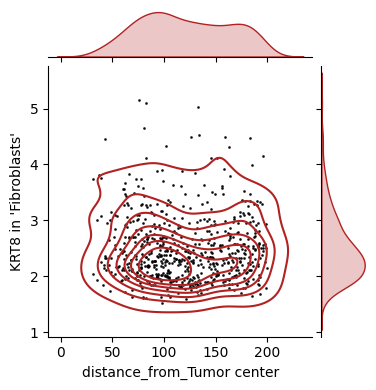

In [34]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
for gene in ["ACTA2", "KRT8"]:
    cell_expression_along_axis(
        adata=adata,
        obs_val=("distance_from", "Tumor center"),
        cell_type_column="cell_type",
        cell_type="Fibroblasts",
        genes=gene,
        xlim=(0, 200),
        min_expression=1.5
        )


In [35]:
from insitupy.plotting.expression_along_axis import _select_data

In [36]:
_select_data(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=["ACTA2", "KRT8"],
    xlim=(0, 200),
)

Retrieve `obs_val` from .obsm.


axis    cell_type     ACTA2      KRT8
4418    194.046942  Fibroblasts  1.000000  1.000000
4420    199.952473  Fibroblasts  1.000000  1.000000
4853    191.115261  Fibroblasts  1.000000  1.000000
4861    199.271144  Fibroblasts  2.741163  1.000000
6140    144.773090  Fibroblasts  1.000000  2.347519
...            ...          ...       ...       ...
118569  156.354595  Fibroblasts  3.434762  1.000000
118570  162.485566  Fibroblasts  3.353267  1.000000
118572  175.984350  Fibroblasts  4.441519  1.000000
118575  147.131136  Fibroblasts  2.825569  1.000000
118576  164.307876  Fibroblasts  4.305654  2.719494

[3052 rows x 4 columns]

Retrieve `obs_val` from .obsm.


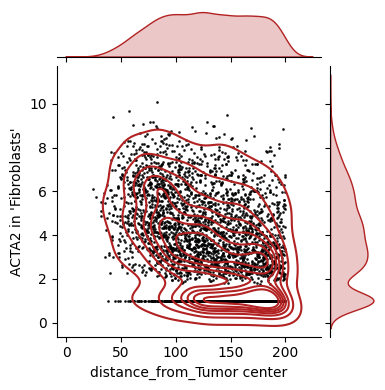

In [37]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=["ACTA2"],
    xlim=(0, 200),
    #min_expression=1.5
    )


Retrieve `obs_val` from .obsm.


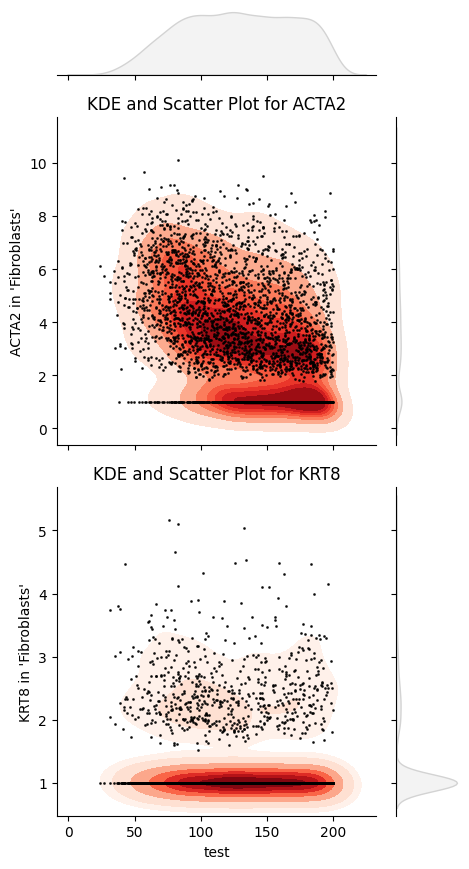

In [38]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=["ACTA2", "KRT8"],
    xlim=(0, 200),
    xlabel="test",
    #min_expression=1.5
    )


# How can we identify significant patterns?

In the SPATA2 paper they work with a metric they call total variation (TV):
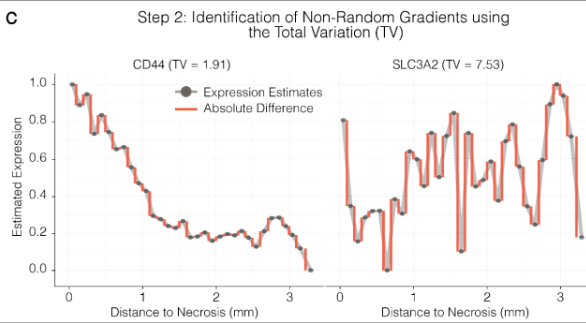
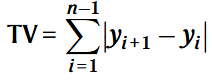

And the significance of a pattern they calculate with following formular:
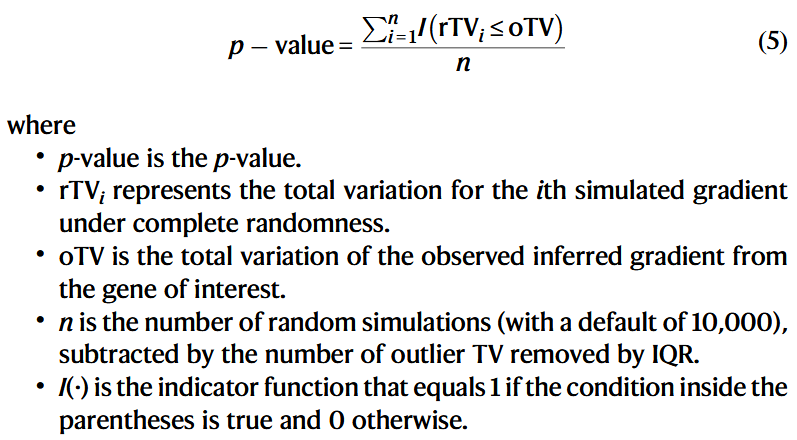

## Using SPATA2 method

### In the method they used the "expression estimates" which seems to be the results of the loess regression:
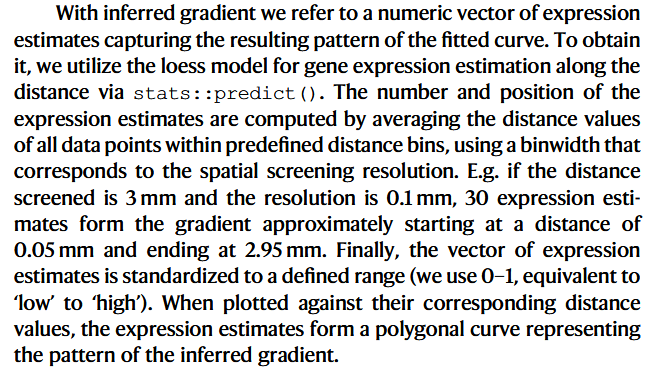

In [39]:
import numpy as np
from insitupy.utils._regression import smooth_fit

In [40]:
_adata = xdcrop.cells.matrix

In [41]:
_adata

AnnData object with n_obs × n_vars = 25443 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'OT', 'X_pca', 'X_umap', 'spatial', 'distance_from', 'density-gauss', 'density_clipped-gauss', 'density-mellon', 'density_clipped-mellon'
    varm: 'OT', 'PCs', 'binned_expression'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [42]:
from tqdm import tqdm
from joblib import delayed, Parallel
import seaborn as sns

In [43]:
from insitupy.plotting.expression_along_axis import _select_data

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
# parameters
gene = "CD68"
nbins = 100

data = _select_data(adata=_adata,
             obs_val=("distance_from", "Tumor center"),
             genes=gene, cell_type_column="cell_type",
             cell_type="Fibroblasts", xlim=(0,400)
             )
data = data.sort_values("axis")
data["bin"] = pd.cut(data["axis"], bins=nbins)
binned_mean = data.groupby("bin")[gene].mean()
binned_mean = binned_mean.reset_index()
scaler = MinMaxScaler()
binned_mean["minmax"] = scaler.fit_transform(binned_mean[[gene]])
binned_mean["bin_center"] = [elem.mid for elem in binned_mean["bin"]]

Retrieve `obs_val` from .obsm.


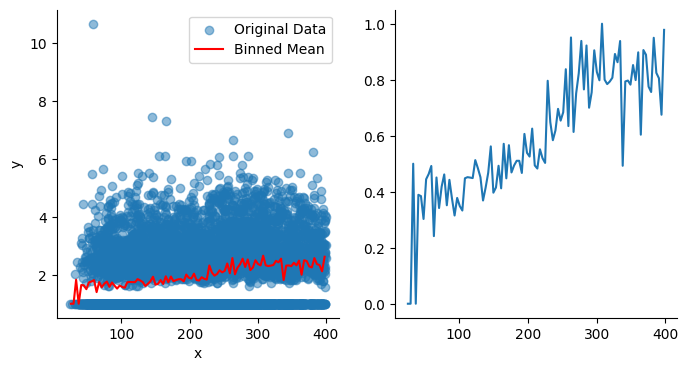

In [46]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
# Plot the original data
axs[0].scatter(data["axis"], data[gene], label='Original Data', alpha=0.5)

# Plot the binned values
axs[0].plot(binned_mean["bin_center"],
         binned_mean[gene],
         color='red',
         #marker='o',
         linestyle='-', label='Binned Mean')

# Add labels and legend
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()

axs[1].plot(binned_mean["bin_center"], binned_mean["minmax"])

# Show plot
plt.show()

In [48]:
binned_mean

bin      CD68    minmax  bin_center
0     (23.645, 27.781]  1.000000  0.000000     25.7130
1     (27.781, 31.541]  1.000000  0.000000     29.6610
2       (31.541, 35.3]  1.829864  0.500020     33.4205
3        (35.3, 39.06]  1.000000  0.000000     37.1800
4      (39.06, 42.819]  1.645540  0.388959     40.9395
..                 ...       ...       ...         ...
95  (381.184, 384.943]  2.576385  0.949823    383.0635
96  (384.943, 388.703]  2.368453  0.824536    386.8230
97  (388.703, 392.463]  2.336497  0.805282    390.5830
98  (392.463, 396.222]  2.120236  0.674978    394.3425
99  (396.222, 399.982]  2.623247  0.978058    398.1020

[100 rows x 4 columns]

In [49]:
res = smooth_fit(
    xs=binned_mean["bin_center"], ys=binned_mean[gene], loess_bootstrap=False, nsteps=100
)

In [50]:
res

x    y_pred       std  conf_lower  conf_upper
0    29.474505  1.426190  0.060335    1.306412    1.545967
1    33.236010  1.440685  0.056382    1.328756    1.552615
2    36.997515  1.455025  0.052665    1.350473    1.559577
3    40.759020  1.469189  0.049198    1.371520    1.566858
4    44.520525  1.483158  0.045992    1.391854    1.574462
..         ...       ...       ...         ...         ...
93  379.294475  2.360964  0.045855    2.269932    2.451996
94  383.055980  2.355691  0.049050    2.258316    2.453065
95  386.817485  2.349826  0.052506    2.245589    2.454062
96  390.578990  2.343374  0.056213    2.231780    2.454967
97  394.340495  2.336340  0.060156    2.216917    2.455762

[98 rows x 5 columns]

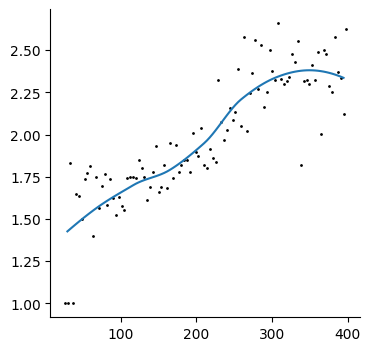

In [51]:
plt.scatter(x=binned_mean["bin_center"], y=binned_mean[gene],s=1, color="k")
plt.plot(res["x"], res["y_pred"])

In [53]:
total_variation(binned_mean[gene].values)

17.99796

In [54]:
total_variation(data[gene].values)

7126.726

# Should the binned values get randomly distributed for calculation of the p value or the original data before binning it? In the SPATA2 paper it sounds like they create random original data for the calculations.

In [56]:
data

axis    cell_type      CD68                 bin
106797   24.021389  Fibroblasts  1.000000    (23.645, 27.781]
106815   26.743697  Fibroblasts  1.000000    (23.645, 27.781]
105783   31.364094  Fibroblasts  1.000000    (27.781, 31.541]
105693   31.573397  Fibroblasts  1.000000      (31.541, 35.3]
106824   31.587514  Fibroblasts  2.043994      (31.541, 35.3]
...            ...          ...       ...                 ...
7389    398.987894  Fibroblasts  3.510173  (396.222, 399.982]
7403    399.047868  Fibroblasts  2.599446  (396.222, 399.982]
55224   399.533768  Fibroblasts  2.594188  (396.222, 399.982]
107721  399.554784  Fibroblasts  3.029120  (396.222, 399.982]
77440   399.981713  Fibroblasts  4.001355  (396.222, 399.982]

[6104 rows x 4 columns]

In [138]:
# Functions
def total_variation(values):
    return np.sum(np.abs(np.diff(values)))

def binned_total_variation(expr, axis, nbins):
    data = pd.DataFrame(
        {"axis": axis,
         "expr": expr}
    )
    # bin data and calculate mean per bin
    data["bin"] = pd.cut(data["axis"], bins=nbins)
    binned_mean = data.groupby("bin")["expr"].mean()
    binned_mean = binned_mean.reset_index()

    # remove empty bins
    binned_mean = binned_mean.dropna()

    # scale values to 0-1
    scaler = MinMaxScaler()
    binned_mean["minmax"] = scaler.fit_transform(binned_mean[["expr"]])

    # extract the center of each bin
    binned_mean["bin_center"] = [elem.mid for elem in binned_mean["bin"]]
    expr = binned_mean["expr"].values
    return total_variation(expr)

# def random_permutation_tv(expr):
#     # Create an array with values from 0 to 10
#     random_order = np.random.permutation(np.arange(len(expr)))
#     expr_random = expr[random_order]

#     return total_variation(expr_random)

def random_permutation_tv(expr, axis, bin_data, nbins):
    # Create an array with values from 0 to 10
    random_order = np.random.permutation(np.arange(len(expr)))
    expr_random = expr[random_order]

    if bin_data:
        tv = binned_total_variation(expr=expr_random, axis=axis, nbins=nbins)
    else:
        tv = total_variation(expr_random)

    return tv

# def random_permutation_tv_precalc(expr, permutations):
#     expr_sorted = expr[permutations]
#     return total_variation(expr_sorted)'

def filter_outliers(data, threshold=1.5):
    """
    Remove values that lie significantly outside the IQR.

    Args:
        data (numpy.ndarray): The input array.
        threshold (float, optional): The multiplier for the IQR to define outliers. Default is 1.5.

    Returns:
        numpy.ndarray: The filtered array with outliers removed.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Filter the array to remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_data



In [139]:
def calculate_total_variation_pval(
    adata,
    obs_val,
    gene,
    cell_type_column,
    cell_type,
    xlim,
    parallel,
    bin_data: bool = False,
    nbins: int = 100,
    n_sim: int = 10000
    ):

    data = _select_data(adata=adata,
                obs_val=obs_val,
                genes=gene, cell_type_column=cell_type_column, cell_type=cell_type, xlim=xlim
                )
    data = data.sort_values("axis")

    # extract values necessary for further analysis
    expr_sorted = data[gene].values
    axis = data["axis"].values

    if bin_data:
        tv_gene = binned_total_variation(expr=expr_sorted, axis=axis, nbins=nbins)
    else:
        tv_gene = total_variation(values=expr_sorted)
    # simulation of random total variations
    # speed up computation with joblib
    if parallel:
        #random_tvs = np.array(Parallel(n_jobs=8)(delayed(random_permutation_tv)(expr_sorted) for _ in range(n_sim)))
        random_tvs = np.array(Parallel(n_jobs=8)(delayed(random_permutation_tv)(expr_sorted, axis, bin_data, nbins) for _ in range(n_sim)))
    else:
        random_tvs = np.array([random_permutation_tv(expr_sorted, axis, bin_data, nbins) for _ in range(n_sim)])
    random_tvs_filtered = filter_outliers(random_tvs)
    n = len(random_tvs_filtered)
    p_val = np.sum(random_tvs_filtered <= tv_gene) / n
    return p_val


In [140]:
pval = calculate_total_variation_pval(
    adata=_adata,
    gene="ACTA2",
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
    bin_data=True, nbins=1000,
    parallel=True, n_sim=100
    )

Retrieve `obs_val` from .obsm.


In [143]:
genes = _adata.var_names.tolist()

In [145]:
from tqdm.auto import tqdm

In [150]:
def run1(genes):
    return np.array([calculate_total_variation_pval(
        adata=_adata,
        gene="ACTA2",
        obs_val=("distance_from", "Tumor center"),
        cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
        bin_data=True, nbins=1000,
        parallel=True, n_sim=100
        ) for gene in tqdm(genes)])

def run2(genes):
    return np.array(Parallel(n_jobs=16)(delayed(calculate_total_variation_pval)(
        _adata, ("distance_from", "Tumor center"), gene, "cell_type", "Fibroblasts", (0,400), False, True, 100, 1000
        ) for gene in tqdm(genes)))

In [151]:
pvals = run2(genes)

  0%|          | 0/313 [00:00<?, ?it/s]

## In the SPATA2 paper they use Benjamini-Hochberg to adjust the p-value and get the FDR

In [168]:
from scipy.stats import false_discovery_control
from statsmodels.stats.multitest import fdrcorrection

In [177]:
fdrcorr = fdrcorrection(pvals, is_sorted=False)
fdrs = fdrcorr[1]
rejected = fdrcorr[0]

In [179]:
rejected.sum()

8

In [176]:
pvals

array([0.91605456, 0.        , 0.00909091, 0.9159919 , 0.07142857,
       0.01128205, 0.58164354, 0.76310273, 0.3566879 , 0.36567926,
       0.17382413, 0.19294606, 0.6483971 , 0.83088235, 0.71047228,
       0.32481363, 0.4       , 1.        , 0.49369748, 0.69875776,
       0.80903491, 0.11318795, 0.36260331, 0.8210075 , 0.4071066 ,
       0.07660455, 0.84141414, 0.07135471, 0.13107822, 0.55025381,
       0.10569106, 0.28258603, 0.9706191 , 0.11404435, 0.75914634,
       0.50159067, 0.43117409, 0.06395939, 0.62738854, 0.58257345,
       0.01671891, 0.80327869, 0.72104733, 0.55636743, 0.00101937,
       0.21057986, 0.04916318, 0.04752066, 0.2402863 , 0.10216718,
       0.25738397, 0.08950617, 0.05209397, 0.03222453, 0.01842375,
       0.27189409, 0.04465213, 0.69968717, 0.06984127, 0.01378579,
       0.68958333, 0.0942623 , 0.48423194, 0.47455867, 0.93135246,
       0.94742268, 0.05797101, 0.57830092, 0.21849593, 0.08105263,
       0.91295117, 0.96256684, 0.83052632, 0.52256034, 0.05241

In [173]:
not_significant_genes = np.array(genes)[fdrs > 0.05]
significant_genes = np.array(genes)[fdrs <= 0.05]

In [174]:
len(not_significant_genes)

305

In [175]:
significant_genes

array(['ACTA2', 'CD14', 'CLEC9A', 'CXCL12', 'DPT', 'EDNRB', 'IL7R',
       'PPARG'], dtype='<U8')

Retrieve `obs_val` from .obsm.


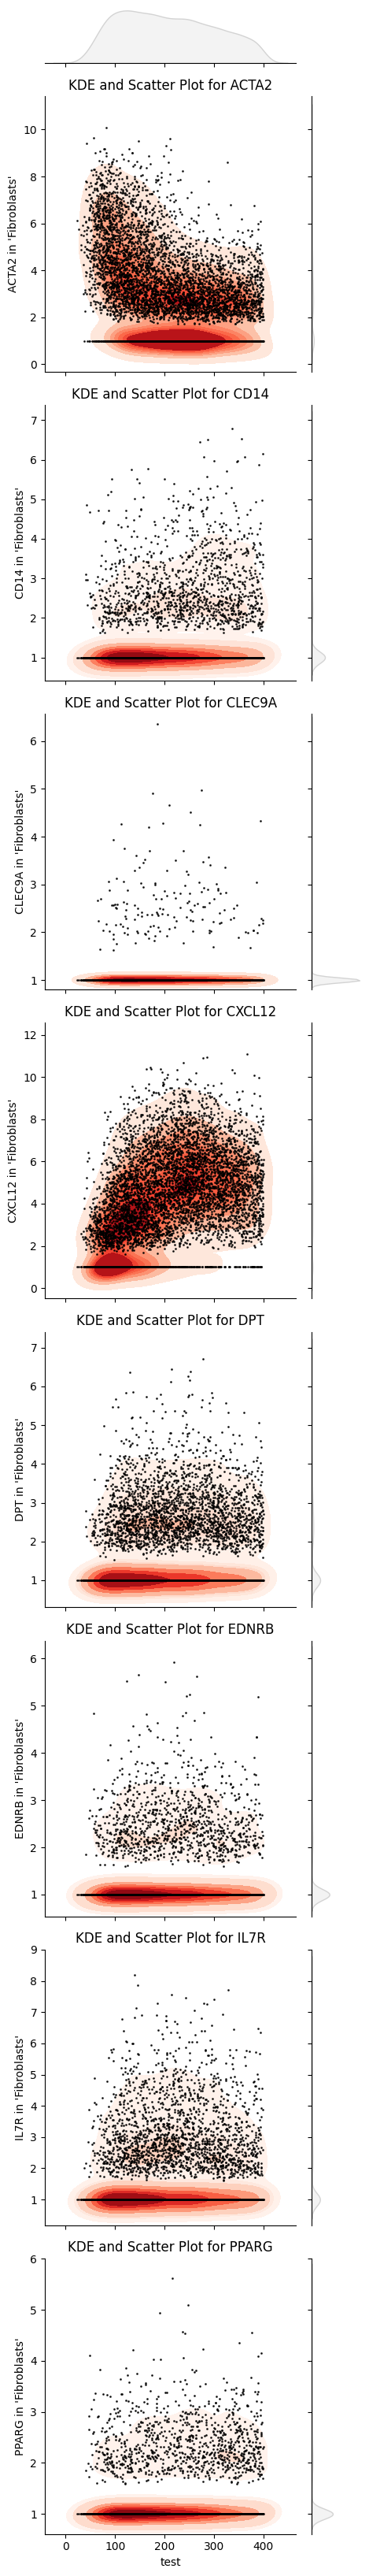

In [167]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=significant_genes,
    xlim=(0, 400),
    xlabel="test",
    #min_expression=1.5
    )


Retrieve `obs_val` from .obsm.


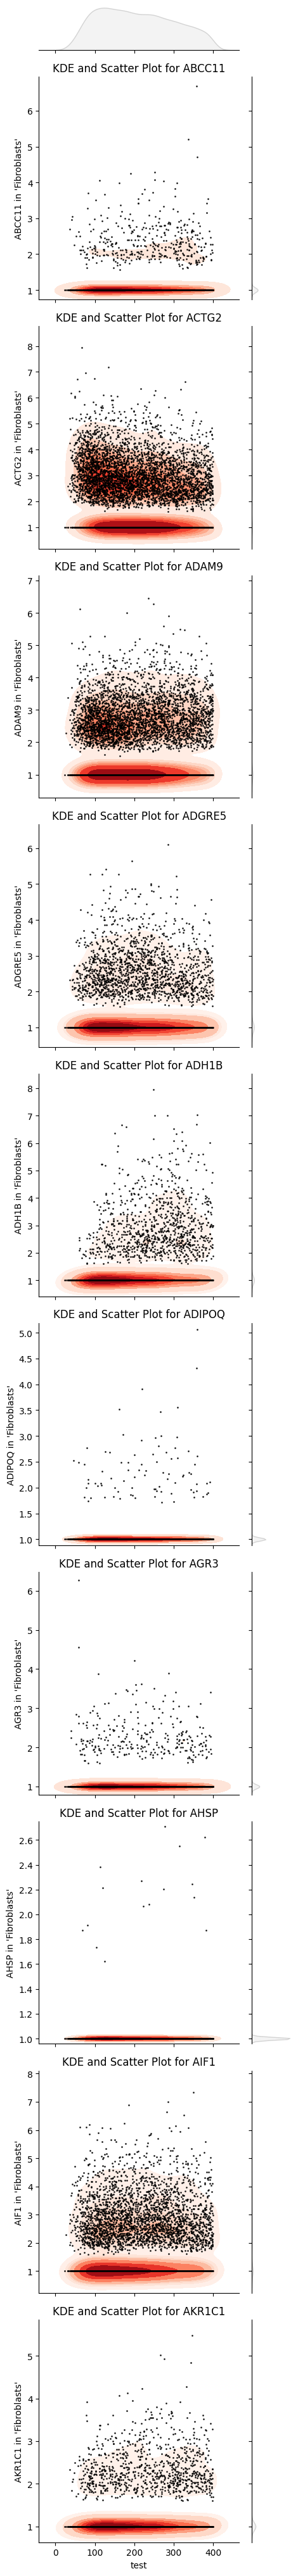

In [180]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=not_significant_genes[:10],
    xlim=(0, 400),
    xlabel="test",
    #min_expression=1.5
    )


Retrieve `obs_val` from .obsm.


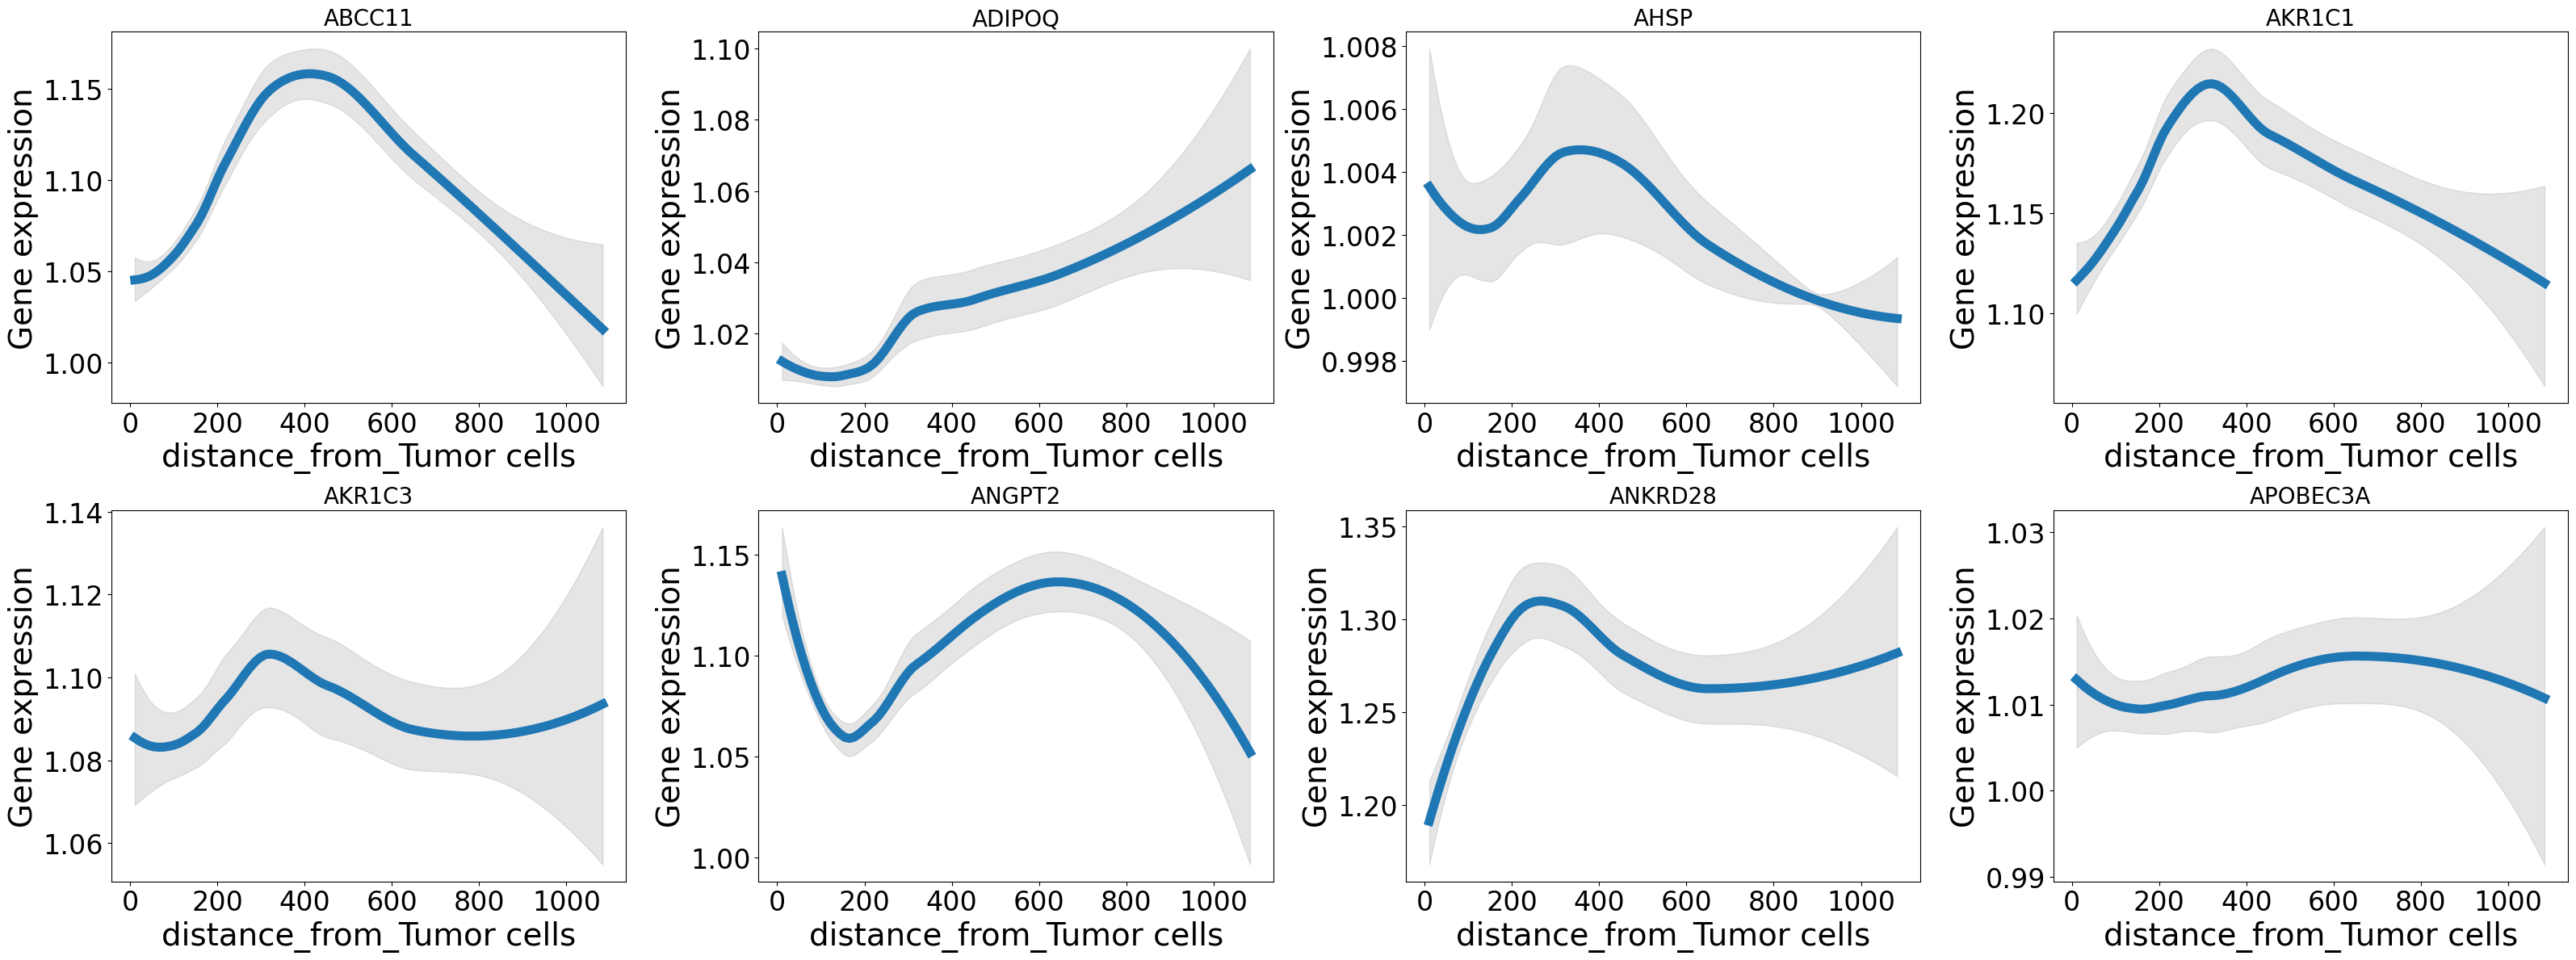

In [49]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=not_significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

Retrieve `obs_val` from .obsm.


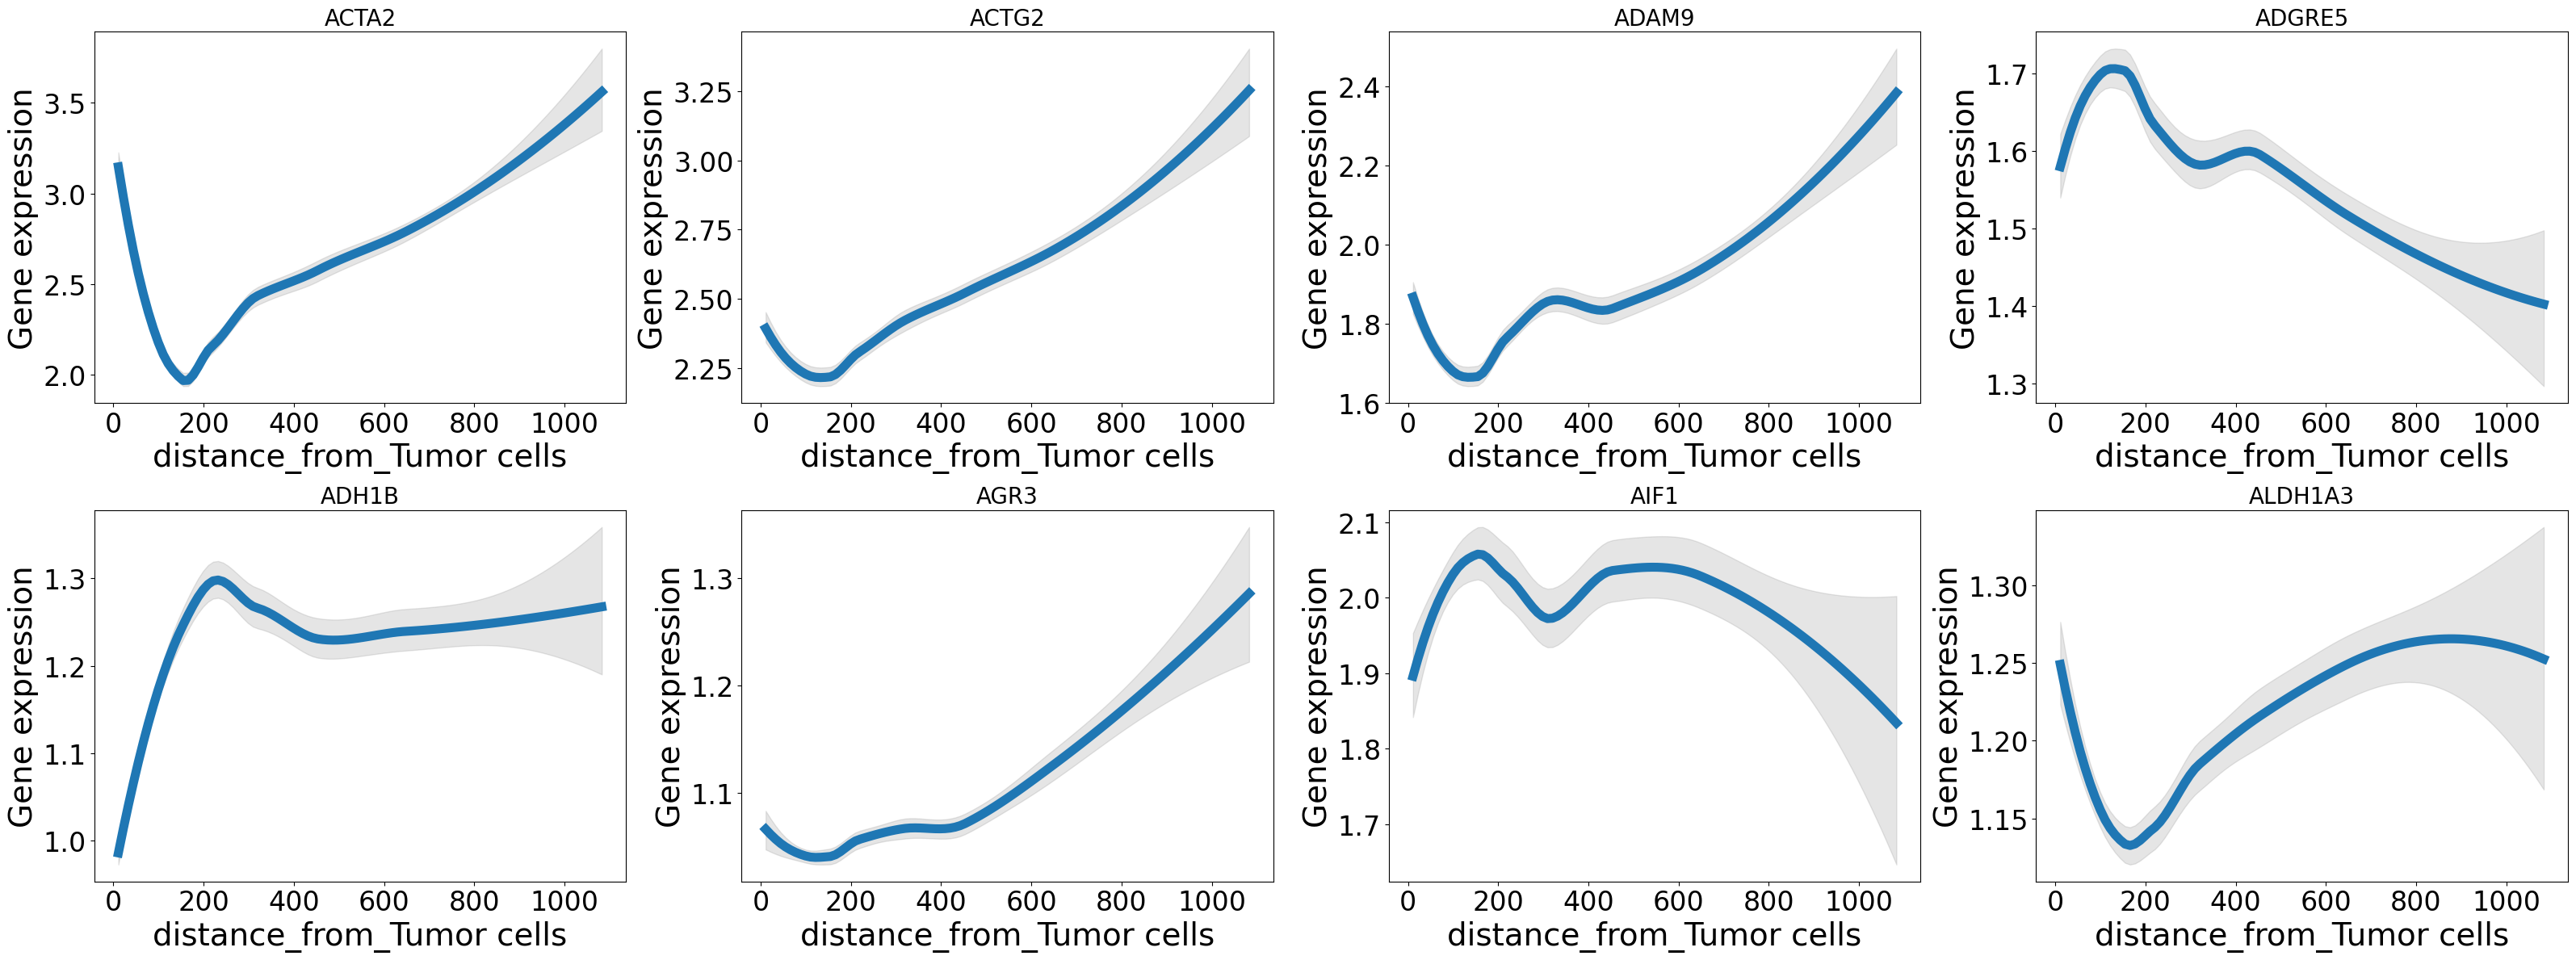

In [50]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

In [51]:
calculate_total_variation_pval(_adata, "AIF1", True)

0.027242457875088284

## Use autocorrelation to select genes

Ljung-Box Test: This is often considered one of the most powerful tests for detecting autocorrelation in time series data, especially when testing multiple lags simultaneously. It is widely used in practice and is robust for various sample sizes.

In [52]:
import statsmodels.api as sm

#load data series
data = sm.datasets.sunspots.load_pandas().data

#view first ten rows of data series
data[:5]

YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0

In [54]:
from statsmodels.tsa.arima.model import ARIMA

In [55]:
#fit ARMA model to dataset
res = ARIMA(data["SUNACTIVITY"], (1,1)).fit(disp=-1)

#perform Ljung-Box test on residuals with lag=5
sm.stats.acorr_ljungbox(res.resid, lags=[5], return_df=True)

ValueError: A constant trend was included in the model specification, but the `exog` data already contains a column of constants.

## Clustering of patterns

In [56]:
df = expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes,
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=False, return_data=True)

Retrieve `obs_val` from .obsm.


In [58]:
df = expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes,
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True, return_data=True)

Retrieve `obs_val` from .obsm.


In [57]:
df

x    y_pred    std
key                                         
ACTA2  None 0     11.094653  3.146789  False
            1     22.145508  2.980164  False
            2     33.196363  2.825612  False
            3     44.247218  2.684409  False
            4     55.298073  2.557813  False
...                     ...       ...    ...
ZNF562 None 93  1038.824168  1.628803  False
            94  1049.875023  1.631820  False
            95  1060.925878  1.634814  False
            96  1071.976733  1.637786  False
            97  1083.027588  1.640736  False

[15092 rows x 3 columns]

In [176]:
# reshape and rename dataframe
df.index = df.index.droplevel(1)
df.index.names = ["gene", "pos"]

In [177]:
df

x    y_pred    std
gene   pos                              
ACTA2  0      11.094653  3.146789  False
       1      22.145508  2.980164  False
       2      33.196363  2.825612  False
       3      44.247218  2.684409  False
       4      55.298073  2.557813  False
...                 ...       ...    ...
ZNF562 93   1038.824168  1.628803  False
       94   1049.875023  1.631820  False
       95   1060.925878  1.634814  False
       96   1071.976733  1.637786  False
       97   1083.027588  1.640736  False

[22736 rows x 3 columns]

### Reshape data

In [178]:
import pandas as pd

In [179]:
regpivot = pd.pivot(df.reset_index(), index="pos", columns="gene", values="y_pred")

In [180]:
regpivot

gene     ACTA2     ACTG2     ADAM9    ADGRE5     ADH1B      AGR3      AIF1  \
pos                                                                          
0     3.146789  2.392529  1.867334  1.579889  0.985708  1.066525  1.896092   
1     2.980164  2.361282  1.831587  1.603033  1.013595  1.061637  1.919326   
2     2.825612  2.332844  1.799005  1.624068  1.040187  1.057201  1.940829   
3     2.684409  2.307552  1.770062  1.642653  1.065512  1.053298  1.960458   
4     2.557813  2.285739  1.745222  1.658453  1.089595  1.050007  1.978069   
..         ...       ...       ...       ...       ...       ...       ...   
93    3.462884  3.177608  2.325069  1.409733  1.263676  1.267574  1.861779   
94    3.487074  3.196144  2.339624  1.407810  1.264618  1.272105  1.855040   
95    3.511539  3.214915  2.354366  1.405958  1.265569  1.276663  1.848192   
96    3.536278  3.233920  2.369295  1.404179  1.266529  1.281248  1.841234   
97    3.561290  3.253160  2.384411  1.402472  1.267496  1.285860  1.834168   

gene    AKR1C1   ALDH1A3   ANKRD29  ...     TRIB1    TUBA4A    TUBB2B  \
pos                                 ...                                 
0     1.116352  1.249027  1.064281  ...  1.208515  1.696718  1.104494   
1     1.118831  1.233323  1.068488  ...  1.209759  1.699844  1.098039   
2     1.121457  1.218712  1.072504  ...  1.211188  1.702376  1.092116   
3     1.124295  1.205272  1.076289  ...  1.212853  1.704122  1.086776   
4     1.127407  1.193080  1.079798  ...  1.214800  1.704889  1.082071   
..         ...       ...       ...  ...       ...       ...       ...   
93    1.120888  1.257480  1.100289  ...  1.493890  1.620616  1.214126   
94    1.119412  1.256347  1.099460  ...  1.494249  1.618122  1.216212   
95    1.117925  1.255139  1.098621  ...  1.494486  1.615587  1.218291   
96    1.116426  1.253857  1.097774  ...  1.494600  1.613010  1.220362   
97    1.114916  1.252500  1.096918  ...  1.494590  1.610392  1.222426   

gene     USP53     VOPP1       VWF      WARS      ZEB1      ZEB2    ZNF562  
pos                                                                         
0     1.214843  2.043518  1.335813  2.094275  2.218891  3.195398  1.401919  
1     1.222464  2.059973  1.323125  2.044854  2.148555  3.178828  1.392091  
2     1.229918  2.075116  1.311638  1.998333  2.082646  3.162654  1.383184  
3     1.237188  2.088844  1.301245  1.955006  2.021644  3.146866  1.375325  
4     1.244258  2.101057  1.291840  1.915164  1.966022  3.131452  1.368640  
..         ...       ...       ...       ...       ...       ...       ...  
93    1.369184  2.011803  1.255705  1.782269  1.952262  2.611603  1.628803  
94    1.366523  2.013812  1.247406  1.781745  1.961370  2.615232  1.631820  
95    1.363773  2.015966  1.239011  1.781133  1.970652  2.619196  1.634814  
96    1.360933  2.018267  1.230523  1.780433  1.980109  2.623497  1.637786  
97    1.358004  2.020715  1.221942  1.779645  1.989742  2.628134  1.640736  

[98 rows x 232 columns]

## Calculate distance matrix from regression lines

Normalization/Z-scoring necessary to make distance measure independent of expression scale.

In [194]:
from dtaidistance import dtw, clustering
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
from insitupy import CustomPalettes
import seaborn as sns

### Perform standardization by z-scoring

In [183]:
norm = stats.zscore(regpivot.T, axis=1)

### Choose color palette

In [186]:
cpal = CustomPalettes()

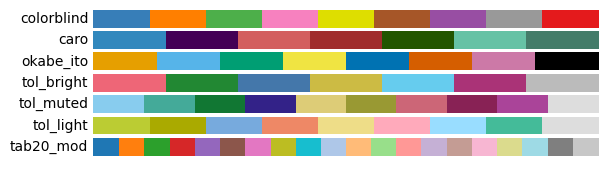

In [187]:
cpal.show_all()

In [188]:
# choose colormap
cmap = cpal.colorblind

### Calculate distance using Dynamic Time Warping and perform hierarchical clustering
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [189]:
# calculate distance matrix
dm = dtw.distance_matrix(norm.values, use_mp=True, use_c=True)
dm = pd.DataFrame(dm, index=norm.index, columns=norm.index)

### Hierarchical clustering
model = clustering.LinkageTree(dtw.distance_matrix, dists_options={'use_mp': True, 'use_c': True})
cluster_id = model.fit(norm.values)

# get linkage
Z = model.linkage

### Select distance threshold for clustering

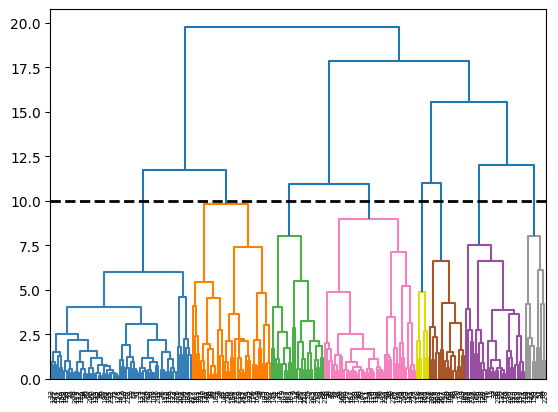

In [192]:
dist_thresh = 10

fig, ax = plt.subplots(1,1)
set_link_color_palette(cmap.colors)
dn = dendrogram(Z, color_threshold=dist_thresh, ax=ax, )
ax.axhline(y=dist_thresh, c="k", linewidth=2, linestyle="dashed")
#plt.savefig("figures/zonated_genes/dendrogram-pattern_clustering.pdf", bbox_inches="tight")
plt.show()

### Extract clusters

In [193]:
# get clusters
clusters = pd.Series(fcluster(Z, t=dist_thresh, criterion='distance'), index=dm.columns, name="cluster")

# map colors to clusters
lut = dict(zip(sorted(clusters.unique()), cmap.colors))
clustercolors = clusters.map(lut)

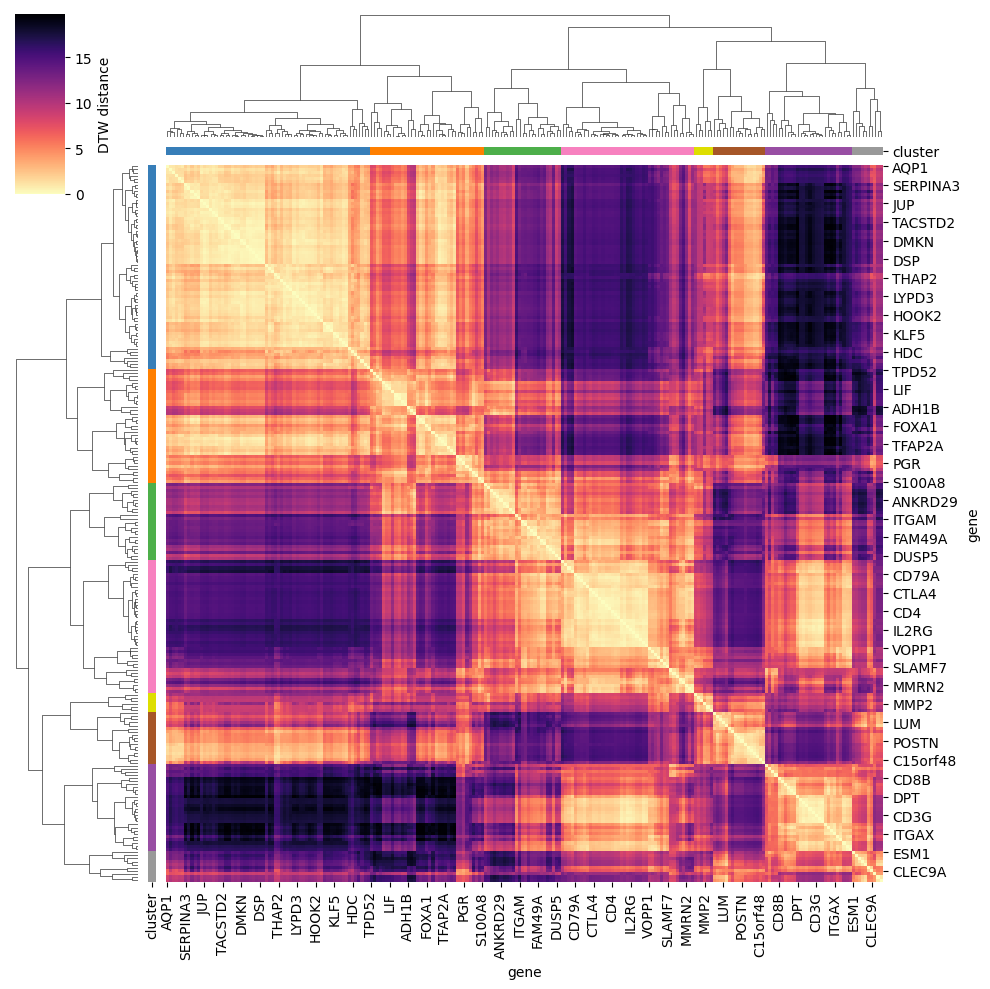

In [195]:
sns.clustermap(dm,
               cmap='magma_r',
               row_linkage=Z, col_linkage=Z,
               row_colors=clustercolors,
               col_colors=clustercolors,
               dendrogram_ratio=0.15, colors_ratio=0.01,
               cbar_kws={
                   'label': 'DTW distance',
               }
              )

#plt.savefig("figures/zonated_genes/heatmap_pattern-clustering.pdf", bbox_inches="tight")
plt.show()

In [196]:
clustercounts = pd.DataFrame(clusters.value_counts()).sort_index()
clustercounts.index.names = ["cluster"]
clustercounts.columns = ["counts"]

C:\Users\ge37voy\AppData\Local\Temp\ipykernel_9076\1440509162.py:2: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(data=clustercounts.reset_index(), x="cluster", y="counts", palette=cmap.colors, ax=ax)


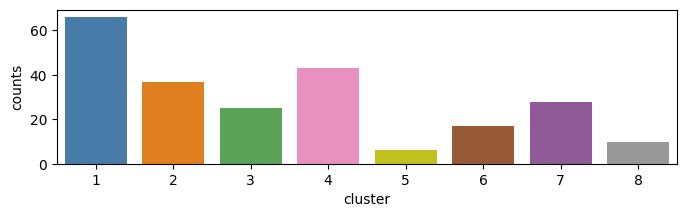

In [197]:
fig, ax = plt.subplots(1,1,figsize=(8,2))
sns.barplot(data=clustercounts.reset_index(), x="cluster", y="counts", palette=cmap.colors, ax=ax)
#plt.savefig("figures/zonated_genes/barplot_clusters.pdf", bbox_inches="tight")
plt.show()

## Plot genes per cluster

In [203]:
cc = clusters.unique()
for c in cc:
    genes = clusters.index[clusters == c]
    expr_along_obs_val(_adata, keys=genes, obs_val=("distance_from", "Tumor cells"),
                             max_cols=6, stderr=True, figsize=(8,4), title_fontsize=40,
                             save_only=True,
                             savepath="figures/zonated_genes/lineplot_cluster-patterning_cluster{}.pdf".format(c)
                            )

Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster6.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster1.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster7.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster2.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster3.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster4.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster8.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster5.pdf
Saved.


In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

## Generate mean regression line per cluster

In [198]:
from sklearn.preprocessing import minmax_scale

In [199]:
# scale
norm_minmax = pd.DataFrame(minmax_scale(norm, axis=1), index=norm.index, columns=norm.columns) * 100

# add cluster information
df = pd.merge(left=norm_minmax, right=clusters, left_index=True, right_index=True)

# reshape to long format
df = df.reset_index().melt(id_vars=["gene", "cluster"], var_name="pos", value_name="expression [%]")

# scale position between 0 and 1
df["pos"] = df["pos"] / df["pos"].max()

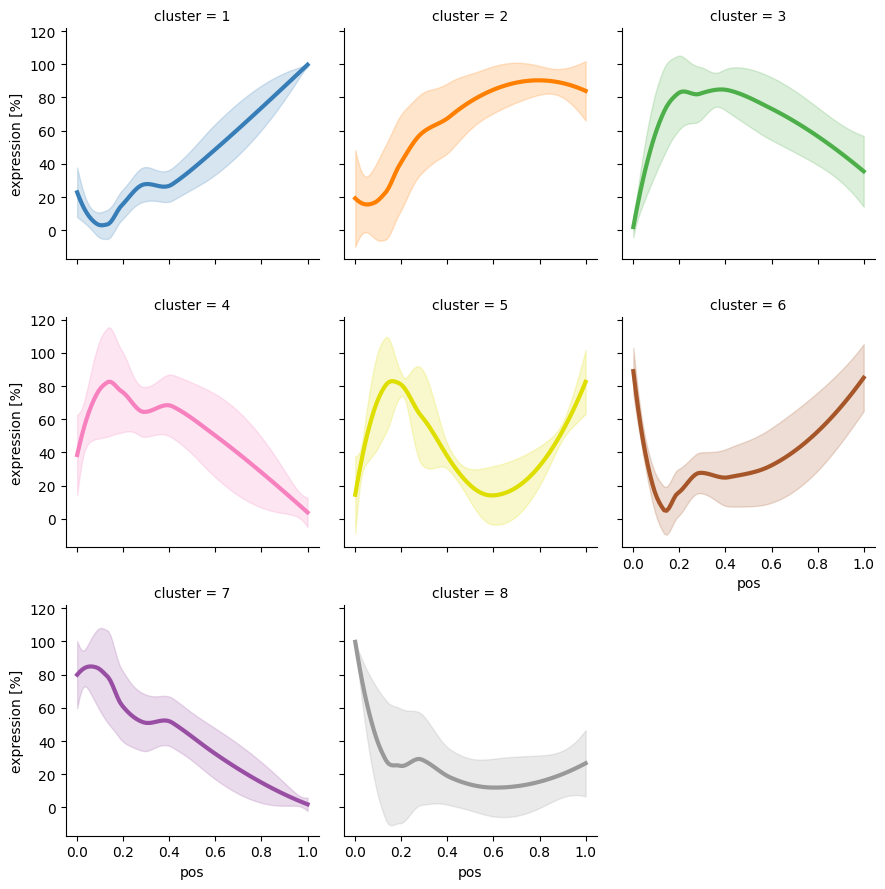

In [200]:
g = sns.FacetGrid(df, col="cluster", hue="cluster", palette=cmap.colors, col_wrap=3)
g.map(sns.lineplot, "pos", "expression [%]", ci="sd", linewidth=3)

#plt.savefig("figures/zonated_genes/lineplot_centerline-per-cluster.pdf", bbox_inches="tight")
plt.show()

## Autocorrelation function

In [ ]:
xd.show()

In [ ]:
#define data
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]

import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [ ]:
#define data
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]

import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [ ]:
sm.tsa.acf(x, nlags=5, fft=False)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962,
       0.03102625])

In [ ]:
sm.tsa.acf(x, nlags=5, fft=True)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962,
       0.03102625])

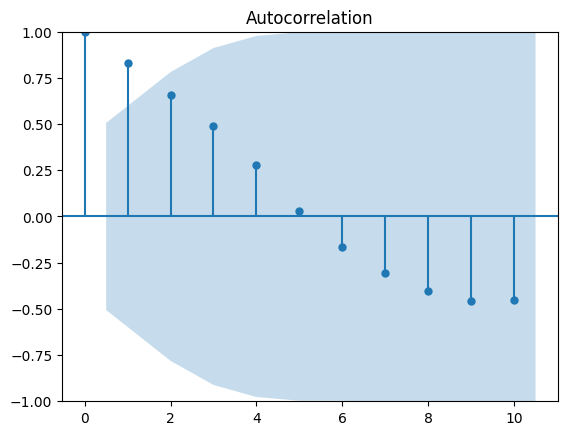

In [ ]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=10)
plt.show()

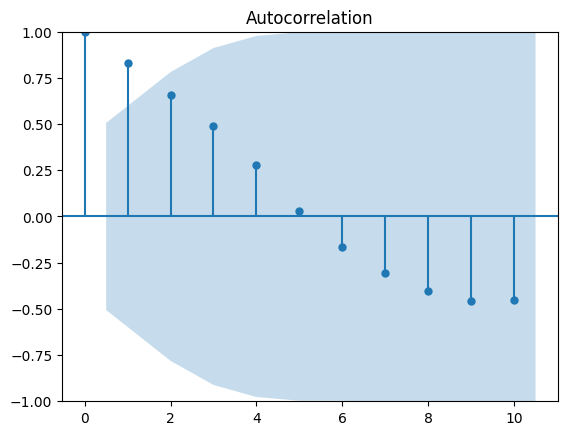

In [ ]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=10, fft=True)
plt.show()

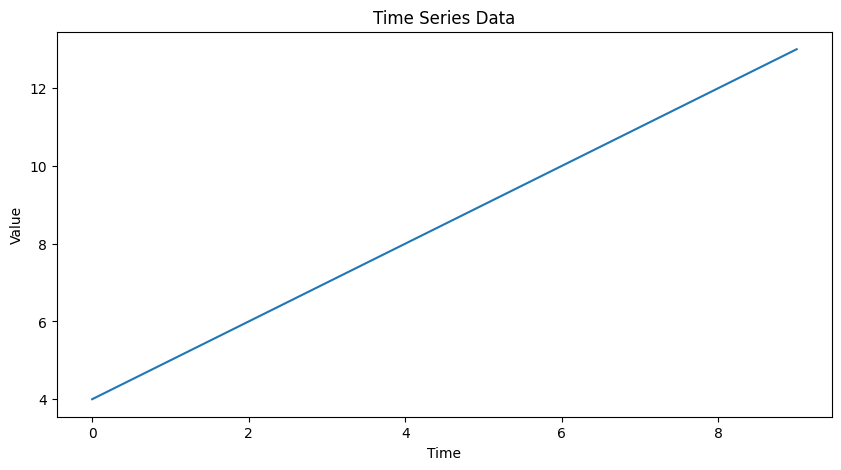

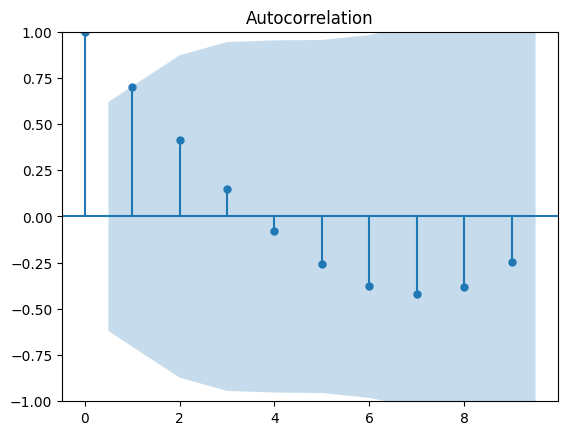

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 9 must be < 5.

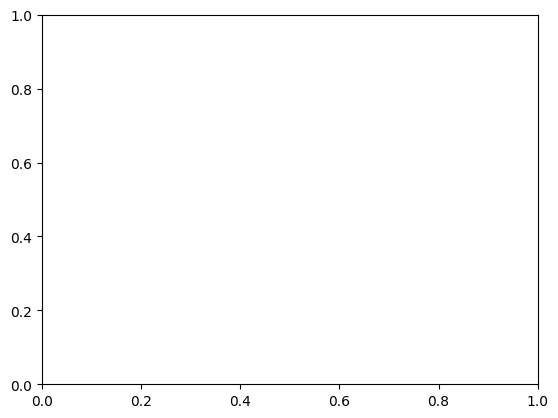

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series data
time_series_data = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series_data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

# ACF and PACF plots
plot_acf(time_series_data, lags=9)
plt.show()

plot_pacf(time_series_data, lags=9)
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(time_series_data)
print('ADF Statistic:', adf_result)
print('p-value:', adf_result)

# Ljung-Box test
lb_test = q_stat(acf(time_series_data, nlags=9, fft=False)[1:], len(time_series_data))
print('Ljung-Box Q-statistic:', lb_test)
print('p-values:', lb_test)
